# About data

Data annotations structure overview.

In [89]:
import json

data_path = './datasets/chongqing1_round1_train1_20191223/annotations.json'
json_data = json.load(open(data_path))
print(json_data.keys())
print('info: ', json_data['info'])
print('license: ', json_data['license'])
print('categories: ', json_data['categories'])
print('images number: ', len(json_data['images']))
print('image sample: ', json_data['images'][0])
print('annotations number: ', len(json_data['annotations']))
print('annotation sample: ', json_data['annotations'][0])

# testing: annotation id repeated
ann_ids = []
for item in json_data['annotations']:
    ann_ids.append(item['id'])
print(len(ann_ids))
print(len(set(ann_ids)))

dict_keys(['info', 'images', 'license', 'categories', 'annotations'])
info:  
license:  []
categories:  [{'supercategory': '瓶盖破损', 'id': 1, 'name': '瓶盖破损'}, {'supercategory': '喷码正常', 'id': 9, 'name': '喷码正常'}, {'supercategory': '瓶盖断点', 'id': 5, 'name': '瓶盖断点'}, {'supercategory': '瓶盖坏边', 'id': 3, 'name': '瓶盖坏边'}, {'supercategory': '瓶盖打旋', 'id': 4, 'name': '瓶盖打旋'}, {'supercategory': '背景', 'id': 0, 'name': '背景'}, {'supercategory': '瓶盖变形', 'id': 2, 'name': '瓶盖变形'}, {'supercategory': '标贴气泡', 'id': 8, 'name': '标贴气泡'}, {'supercategory': '标贴歪斜', 'id': 6, 'name': '标贴歪斜'}, {'supercategory': '喷码异常', 'id': 10, 'name': '喷码异常'}, {'supercategory': '标贴起皱', 'id': 7, 'name': '标贴起皱'}]
images number:  4516
image sample:  {'file_name': 'img_0017151.jpg', 'height': 492, 'id': 1, 'width': 658}
annotations number:  6945
annotation sample:  {'area': 2522.739400000001, 'iscrowd': 0, 'image_id': 1, 'bbox': [165.14, 53.71, 39.860000000000014, 63.29], 'category_id': 2, 'id': 213}
6945
2011


## Data preprocess

- Filter the category of `id=0`, which stands for the background while offering nothing for the detection task!
- Missing segmentation item, complete it!
- Re-index annotation id

In [90]:
def bbox_to_segm(bbox):
    x, y, w, h = bbox[:4]
    segm = [[
        x,y,
        x+w,y,
        x+w,y+h,
        x,y+h
    ]]
    return segm

In [91]:
processed_data = {}
processed_data['info'] = json_data['info']
processed_data['license'] = json_data['license']
processed_data['images'] = json_data['images']
# remove `背景`
remove_catId = [0]
processed_data['categories'] = []
for item in json_data['categories']:
    if item['id'] in remove_catId:
        continue
    processed_data['categories'].append(item)

# complete `segmentation` item in annotation
processed_data['annotations'] = []
ann_id = 1
for item in json_data['annotations']:
    if item['category_id'] in remove_catId:
        continue
    item['id'] = ann_id
    item['segmentation'] = bbox_to_segm(item['bbox'])
    processed_data['annotations'].append(item)
    ann_id += 1

# write to file
with open('./datasets/chongqing1_round1_train1_20191223/coco_annotations.json', 'w') as w_obj:
    json.dump(processed_data, w_obj)
    

## Visualize annotation

In [1]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

data_path = './datasets/chongqing1_round1_train1_20191223/coco_annotations.json'
# show the whole categories
coco = COCO(data_path)
categories = coco.loadCats(coco.getCatIds())
category_names = [category['name'] for category in categories]
print('Custom COCO categories: \n{}\n'.format(' '.join(category_names)))

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Custom COCO categories: 
瓶盖破损 喷码正常 瓶盖断点 瓶盖坏边 瓶盖打旋 瓶盖变形 标贴气泡 标贴歪斜 喷码异常 标贴起皱



In [13]:
# choose visual image
category_ids = coco.getCatIds(catNms=['瓶盖破损'])
image_ids = coco.getImgIds(catIds=category_ids)
selected_id = image_ids[np.random.randint(0, len(image_ids))]
image_data = coco.loadImgs(selected_id)[0]
print(image_data)

{'file_name': 'img_0018512.jpg', 'height': 492, 'id': 2181, 'width': 658}


{'area': 889.7719999999991, 'iscrowd': 0, 'image_id': 2181, 'bbox': [391.43, 85.71, 19.279999999999973, 46.15000000000002], 'category_id': 1, 'id': 2827, 'segmentation': [[391.43, 85.71, 410.71, 85.71, 410.71, 131.86, 391.43, 131.86]]}
{'area': 8750.73999999999, 'iscrowd': 0, 'image_id': 2181, 'bbox': [382.29, 181.71, 44.41999999999996, 196.99999999999997], 'category_id': 1, 'id': 2828, 'segmentation': [[382.29, 181.71, 426.71, 181.71, 426.71, 378.71, 382.29, 378.71]]}
{'area': 585.0, 'iscrowd': 0, 'image_id': 2181, 'bbox': [358.29, 340.0, 13.0, 45.0], 'category_id': 1, 'id': 2829, 'segmentation': [[358.29, 340.0, 371.29, 340.0, 371.29, 385.0, 358.29, 385.0]]}


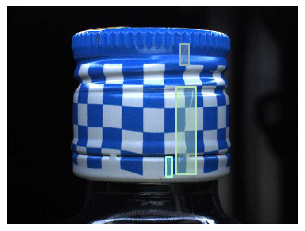

In [14]:
# get the whole annotations and visulize
image_directory = './datasets/chongqing1_round1_train1_20191223/images/'
image = io.imread(image_directory + image_data['file_name'])
plt.imshow(image)
plt.axis('off')
#pylab.rcParams['figure.figsize'] = (50.0, 50.0)
annotation_ids = coco.getAnnIds(imgIds=image_data['id'], catIds=[], iscrowd=None)
annotations = coco.loadAnns(annotation_ids)
coco.showAnns(annotations)
for ann in annotations:
    print(ann)